# Running models on the GPU

Let's redo the MNIST image classification example but this time run the network on the GPU.

The only difference is that we select a `torch.device` like `cuda:0` (first GPU) and then make sure that we use `.to(device)` on the tensors holding our data and the models that we create. Other than that, it's the same.

Now, sometimes we have to compute values and back on the CPU and so we need to extract the results.  We can pull it back using `.cpu()` on a variable.

The other thing to worry about is the auto gradient mechanism. It secretly tracks the gradient for all tensors used in the loss computation so that we can perform gradient descent. That auto gradient computation graph can get quite large and if we need just the value, we call `.item()` on the tensor.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

# Figure out whether we have a GPU; if not use the CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
def plot_loss(history, ax=None, maxy=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    loss = history[:,0]
    val_loss = history[:,1]
    if maxy:
        ax.set_ylim(0,maxy)
    else:
        ax.set_ylim(0,torch.max(val_loss))
    ax.plot(loss, label='train_loss')
    ax.plot(val_loss, label='val_loss')
    ax.legend(loc='upper right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/parrt/Desktop/{file}.pdf")
        
def plot_accur(history, ax=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epochs")
    accur = history[:,2]
    val_accur = history[:,3]
    ax.set_ylim(0,1.05)
    ax.plot(accur, label='accur')
    ax.plot(val_accur, label='val_accur')
    ax.legend(loc='lower right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/parrt/Desktop/{file}.pdf")
        
def imgrid(images, digits, dim=(5,5), figsize=(4, 4)):
    fig, axes = plt.subplots(*dim, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        img_as_row = images[i]
        img28x28 = img_as_row.reshape(28,28)
        ax.axis('off') # don't show x, y axes
        ax.imshow(img28x28, cmap='Greys')
        ax.text(0, 8, digits[i], color='#313695', fontsize=15)

## Load data

Let's use a subset of the well-known MNIST handwritten digits data set. This is like the "hello world" of image recognition for deep learning. 

In [3]:
df_mnist = pd.read_csv("https://mlbook.explained.ai/data/mnist-10k-sample.csv.zip")
X = df_mnist.drop('digit', axis=1).values # get just pixels
y = df_mnist['digit'].values              # get just digit value

In [4]:
X.shape

(10000, 784)

In [5]:
# shuffle
n = len(X)
idx = np.random.randint(0,n,n)
X = X[idx,:]
y = y[idx]

In [6]:
X.shape

(10000, 784)

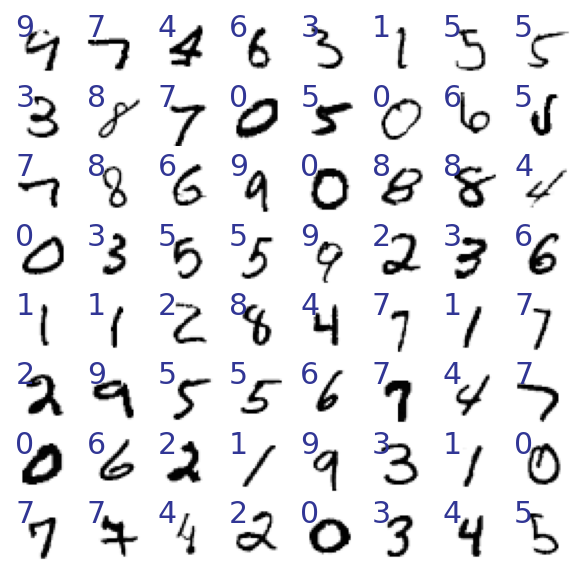

In [7]:
imgrid(X,digits=y,dim=(8,8),figsize=(5,5))

Now, let's create tensors from the X and y data; also indicate we want that data on the GPU:

In [8]:
X = torch.tensor(X).float().to(device)
y = torch.tensor(y).to(device)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Training loop

In [9]:
def ctrain(model, X_train, y_train, X_test, y_test, 
           learning_rate = .0001, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = []
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        # Assume model yields softmax probabilities
        # We definitely need to have auto gradient computed here
        loss = F.cross_entropy(y_pred, y_train)

        # This construct is for memory efficiency and speed;
        # means to avoid doing any of the auto gradient computations
        # in this block of code
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, axis=1)
            ncorrect = torch.sum(y_pred==y_train)
            accur = ncorrect.float() / len(y_train)

            y_test_pred = model(X_test)
            loss_test = F.cross_entropy(y_test_pred, y_test)
            y_test_pred = torch.argmax(y_test_pred, axis=1)
            ncorrect = torch.sum(y_test_pred==y_test)
            loss_accur = ncorrect.float() / len(y_test)
        
        # Save all of the computations; loss.item() detaches
        # the hidden auto gradient computation graph.
        # Gets just the value. Otherwise, this procedure
        # runs out of memory on the GPU. 
        history.append((loss.item(), loss_test, accur, loss_accur))
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} cross entropy loss {loss:7.4f}   test loss {loss_test:7.4f}")

        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"LAST        cross entropy loss {loss:7.4f}")
    return torch.tensor(history)

In [10]:
# make sure to create a new model otherwise it starts from where it left off
model = nn.Sequential(
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

model = model.to(device) # make sure the model runs on the GPU as well

In [11]:
# On the CPU, this will take a very long time so
# use nepochs=1000 instead if you don't have a GPU
history = ctrain(model, X_train, y_train, X_test, y_test,
                 learning_rate = .03, nepochs=5000)

Epoch    0 cross entropy loss  2.3024   test loss  2.3024
Epoch  500 cross entropy loss  1.4800   test loss  1.5041
Epoch 1000 cross entropy loss  1.4770   test loss  1.4975
Epoch 1500 cross entropy loss  1.4770   test loss  1.4973
Epoch 2000 cross entropy loss  1.4750   test loss  1.4953
Epoch 2500 cross entropy loss  1.4746   test loss  1.4953
Epoch 3000 cross entropy loss  1.4746   test loss  1.4949
Epoch 3500 cross entropy loss  1.4783   test loss  1.4964
Epoch 4000 cross entropy loss  1.4778   test loss  1.4971
Epoch 4500 cross entropy loss  1.4778   test loss  1.4963
Epoch 5000 cross entropy loss  1.4778   test loss  1.4959
LAST        cross entropy loss  1.4778


In [12]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.983


In [13]:
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.965


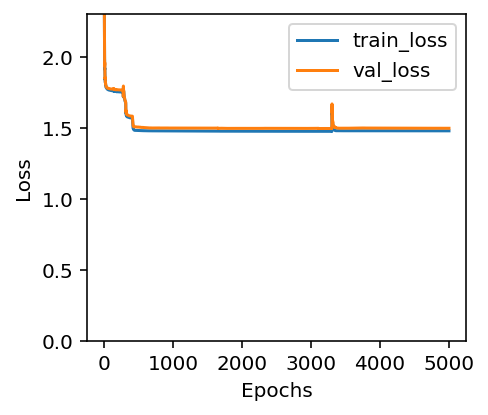

In [14]:
plot_loss(history)

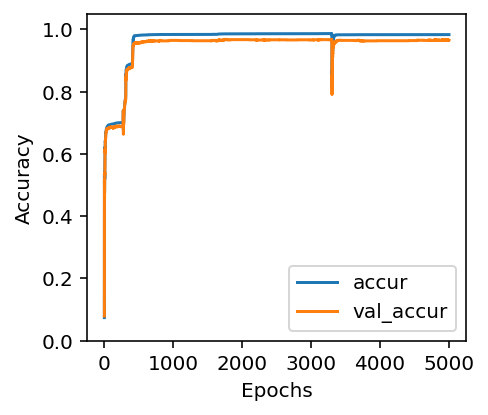

In [15]:
plot_accur(history)